<a href="https://colab.research.google.com/github/zuryeong519/Card-transaction-abnormality-detection-system/blob/main/%EC%B9%B4%EB%93%9C%EA%B1%B0%EB%9E%98%EC%9D%B4%EC%83%81%ED%83%90%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실습목표
- 인공지능 모델을 만들기 전에 과제를 어떻게 정의하는지 알 수 있다.
- 타인의 정의된 과제를 살펴보고 필요한 추가 정보가 무엇인지 생각하는 과정을 이해한다.
- 분류 예측 문제를 해결하는 인공지능 모델을 만들 수 있다.
- 모델의 평가지표에 대해 이해하고 적절한 평가지표를 인공지능 모델에 적용할 수 있다.


# 과제 정의

- 신용울 바탕으로 하는 금융거래 중 하나는 신용카드결제이다.
- (주)김한카드는 최근 콜센터 내용을 분석한 결과 신용카드 결재가 본인이 아니라는 주장이 증가하는 추세를 파악하였다.
- 주장의 내용에 대한 민원처리 결과를 검토해 보니, 실제로 카드 소유주가 구매한 물건이 아닌 거래가 있었다.
- 이에 과거의 결재 정보를 이용하여 이상거래 여부를 인공지능으로 판단하고자 한다.
- 향후 모든 거래에 대하여 이상거래 여부를 판단하여 경고할 수 있도록 서비스를 준비하기 위한 과정이다.

# 데이터 세트

- 데이터 세트명 : Credit Card Fraud Detection
- 데이터 세트 출처 : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

# 데이터 세트 상세 설명

- 데이터는 284,807건이며, 총 31개의 컬럼으로 구성됨
- 이상거래여부(Class), 거래시간(Time)과 거래금액(Amount)을 제외하고 나머지 값은 차원축소(PCA)된 값이다.
- Class 컬럼이 예측을 해야하는 이상거래 여부이다.
  - 보편적으로 관심있는 값을 1, 아닌 경우를 0 으로 설정

- Time : Unix 시스템으로 작성된 거래일시
- V1 ~ V28 : 원본 데이터를 차원축소한 값
- Amount : 거래금액
- Class : 이상거래여부 (0-정상, 1-이상)


# 모델의 성능 지표 (Metric) : ROC_AUC <font size=3> (Receiver Operating Characteristic, Area Under the Curve)</font>
- 이진분류 문제의 예측력을 측정하기 위하여 사용
- 관심있는 데이터라고 판단하는 임계값을 조정하여 결과를 바꿀 수 있는 측정방법을 보완


### 혼동행렬 (Confusion Matrix)에서 측정가능한 지표들
- 정확도(Accuracy) : 정확하게 예측한 수(TP+TN) / 전체 데이터 수(TP+TN+FP+FN)
- 정밀도(Precision) : 진짜 양성 데이터 수(TP) / 양성으로 예측한 데이터(TP+FP)
- 재현율(Recall) : 진짜 양성 데이터 수(TP) / 전체 양성 데이터 수(TP+FN)
- F1-Score : 정밀도(Precision)와 재현율(Recall)의 조화평균 = 2 * (정밀도 * 재현율) / (정밀도 + 재현율)

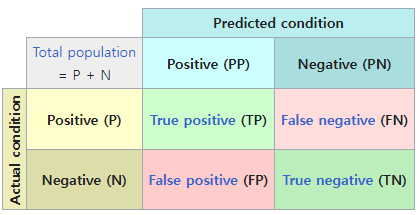

<font size=2> [ 출처 : https://en.wikipedia.org/wiki/Confusion_matrix ]</font>

In [1]:
# 필수 패키지 로드
import gdown
import pandas as pd

from sklearn.metrics import roc_auc_score

import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


- [설명]
  - 패키지는 import 되는 시점에 일부 메모리를 점유하게 된다.
  - 따라서 사용하지 않는 패키지는 import를 하지 않음으로 메모리를 절약할 수 있다.
  - 다만, 운영환경에서 실제 서비스를 하는 경우가 아닌, 개발하는 과정에서는 필요하지 않은 작업이다.
  - 사용하지 않는 패키지는 전체 프로그램을 코드를 살펴봐야 알 수 있다.
  - 하나씩 검색하여 사용 여부를 확인하는 과정이 필요하다.  


In [2]:
# 파일 다운로드
google_path = 'https://drive.google.com/uc?id='
file_id = '1cA2bkyBdPvNFX8yiL-kyczqlfv8YvjLK'
output_name = 'train.csv'
gdown.download(google_path+file_id, output_name)

Downloading...
From (original): https://drive.google.com/uc?id=1cA2bkyBdPvNFX8yiL-kyczqlfv8YvjLK
From (redirected): https://drive.google.com/uc?id=1cA2bkyBdPvNFX8yiL-kyczqlfv8YvjLK&confirm=t&uuid=6e5255ec-2716-4056-bf60-48638abfd90a
To: /content/train.csv
100%|██████████| 151M/151M [00:02<00:00, 54.1MB/s]


'train.csv'

In [3]:
# 파일을 불러오고 10개의 컬럼만 실습대상으로 제한
train = pd.read_csv('train.csv')

print('제한 전 train 데이터 크기 : ', train.shape)

train = train.iloc[:, [0,1,2,3,4,5,6,7,8,9,-2,-1]]  # 11개 컬럼으로 제한
print('제한 후 train 데이터 크기 : ', train.shape)

train

제한 전 train 데이터 크기 :  (284807, 31)
제한 후 train 데이터 크기 :  (284807, 12)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,10.00,0


- [설명]
  - 학습에 사용하는 컬럼은 데이터 특징으로 사용되며, 데이터 모델에 영향을 주게 된다.
  - 얼마큼의 영향을 주는지, 어떤 컬럼이 영향을 주는지 등은 모델을 만들어봐야 하는 실험이 필요하다.

In [5]:
# 파일을 불러오고 10개의 컬럼만 실습대상으로 제한
train = pd.read_csv('train.csv')

print('제한 전 train 데이터 크기 : ', train.shape)

train = train[['Time', 'V1', 'V2', 'V3', 'V4', 'V6', 'V7', 'V8', 'V9', 'Amount', 'Class']]  # 11개 컬럼으로 제한
print('제한 후 train 데이터 크기 : ', train.shape)

train

제한 전 train 데이터 크기 :  (284807, 31)
제한 후 train 데이터 크기 :  (284807, 11)


,Time,V1,V2,V3,V4,V6,V7,V8,V9,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,0.462388,0.239599,0.098698,0.363787,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,-0.082361,-0.078803,0.085102,-0.255425,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,1.800499,0.791461,0.247676,-1.514654,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,1.247203,0.237609,0.377436,-1.387024,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,0.095921,0.592941,-0.270533,0.817739,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-2.606837,-4.918215,7.305334,1.914428,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,1.058415,0.024330,0.294869,0.584800,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,3.031260,-0.296827,0.708417,0.432454,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,0.623708,-0.686180,0.679145,0.392087,10.00,0


In [6]:
# 결측치 확인
train.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V6,0
V7,0
V8,0
V9,0
Amount,0


# 데이터 구조 파악

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   Amount  284807 non-null  float64
 10  Class   284807 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 23.9 MB


In [8]:
# 결측치 확인
train.isnull().sum()[train.isnull().sum() > 0]

,0


# 탐색적 자료 분석 (EDA, Exploratory Data Analysis)

In [9]:
# 각 컬럼의 값 확인
train['Time'].value_counts()

,count
Time,
163152.0,36
64947.0,26
68780.0,25
3767.0,21
3770.0,20
...,...
127750.0,1
62260.0,1
62259.0,1


<Axes: >

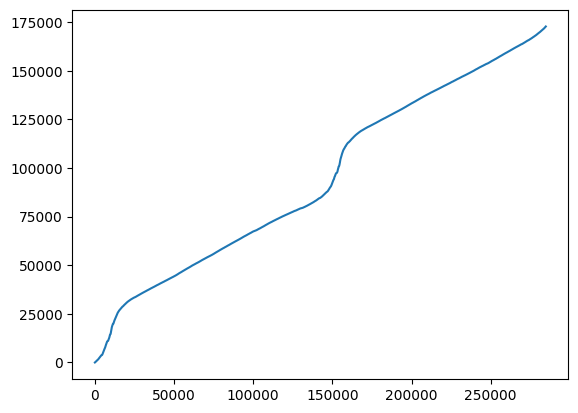

In [10]:
train['Time'].plot()

In [11]:
# 각 컬럼의 값 확인
train['Amount'].value_counts()

,count
Amount,
1.00,13688
1.98,6044
0.89,4872
9.99,4747
15.00,3280
...,...
62.09,1
552.05,1
1467.75,1


<Axes: >

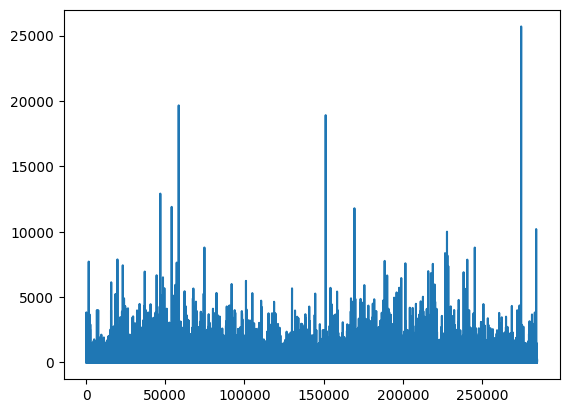

In [12]:
train['Amount'].plot()

  - 위 시각화에서는 거래금액이 매우 평준화되어 보이며,
  - 간혹 매우 높게 발생하는 거래량이 있어 자세한 확인이 필요해 보인다.

In [13]:
# 각 컬럼의 값 확인
train['Class'].value_counts()

,count
Class,
0,284315
1,492


In [14]:
# 비율확인
train['Class'].value_counts(normalize=True)

,proportion
Class,
0,0.998273
1,0.001727


<Axes: xlabel='Class'>

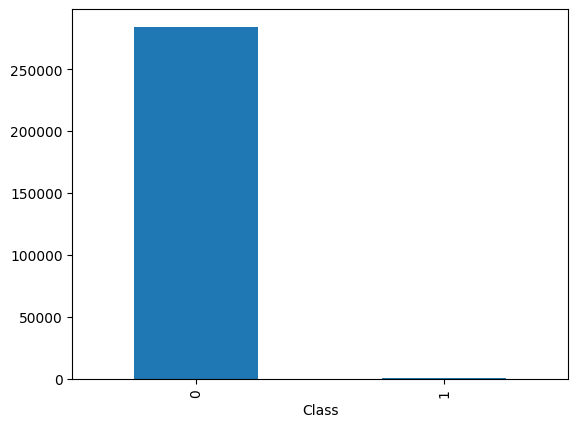

In [15]:
# Class 시각화
train['Class'].value_counts().plot(kind='bar')

In [16]:
# 기초통계량 확인
train.describe()

,Time,V1,V2,V3,V4,V6,V7,V8,V9,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,25691.160000,1.000000


# 학습 데이터, 검증 데이터 분리

In [17]:
# 총 284,807건의 데이터를 280,000 : 4,807 으로 분리하여 280,000 건으로 학습하고, 4,807건으로 검증
train_data = train[:280000]
valid_data = train[280000:]

train_data.shape, valid_data.shape

((280000, 11), (4807, 11))

In [18]:
# 학습용 데이터 준비
x_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]

x_train.shape, y_train.shape

((280000, 10), (280000,))

In [19]:
x_train

,Time,V1,V2,V3,V4,V6,V7,V8,V9,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,0.462388,0.239599,0.098698,0.363787,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,-0.082361,-0.078803,0.085102,-0.255425,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,1.800499,0.791461,0.247676,-1.514654,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,1.247203,0.237609,0.377436,-1.387024,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,0.095921,0.592941,-0.270533,0.817739,69.99
...,...,...,...,...,...,...,...,...,...,...
279995,169235.0,1.992134,-0.568197,-0.483177,0.255276,-0.121949,-0.812815,0.163114,1.151521,6.47
279996,169235.0,-1.852996,-0.806818,-0.175668,-2.265274,2.618106,1.652370,0.496252,-0.979692,565.11
279997,169236.0,1.866029,0.282282,0.116332,3.571717,0.554990,-0.560569,0.299129,-0.608678,1.00
279998,169237.0,2.178247,-1.472885,-0.697008,-1.419590,-0.852524,-1.043807,-0.290200,-1.240592,66.00


In [20]:
# 검증용 데이터 준비
x_valid = valid_data.iloc[:, :-1]
y_valid = valid_data.iloc[:, -1]

x_valid.shape, y_valid.shape

((4807, 10), (4807,))

# 모델 학습

In [21]:
# 학습
params = {
    'n_estimators': 600,
    'learning_rate': 0.01,
    'num_leaves': 30,
    'objective': 'binary',
    'random_state': 42,
    'boost_from_average': False,  # 불균형 데이터 학습의 경우 필수 적용 v2.1.0 이상
}

model = lgb.LGBMClassifier(**params)
model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric='auc')

[LightGBM] [Info] Number of positive: 488, number of negative: 279512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 280000, number of used features: 10


LGBMClassifier(boost_from_average=False, learning_rate=0.01, n_estimators=600,
               num_leaves=30, objective='binary', random_state=42)


  - n_estimators : 모델이 생성할 트리의 수이며 적으면 과소적합, 많으면 과대적합이 발생한다.
  - learning_rate : 학습속도를 의미하며 크면 과적합, 작으면 학습이 느리고 과소적합될 수 있다.
  - num_leaves : 트리의 최대 리프(leaf) 수를 지정하는 것으로 크면 과대적합, 작으면 과소적합될 수 있다.
  - random_state : 모델이 생성되면 초기에 필요한 값이 있습니다. 이 값을 고정하는 임의 수치이다.
  - boost_from_average : 초기 값을 훈련 데이터의 평균값을 사용할지 여부를 설정한다.

# 모델 예측

In [22]:
# 예측
y_pred = model.predict_proba(x_valid)[:, 1]
valid_data['pred'] = y_pred
valid_data

<ipython-input-22-c878a4451ea2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['pred'] = y_pred


,Time,V1,V2,V3,V4,V6,V7,V8,V9,Amount,Class,pred
280000,169243.0,-1.764854,-1.008565,-1.446101,0.063075,-1.618682,0.333263,0.129326,-0.656255,40.98,0,0.001378
280001,169243.0,-1.829431,2.410933,-2.228766,-0.909502,-0.009877,-0.484311,0.606725,-0.191322,13.99,0,0.001340
280002,169243.0,2.050538,-0.108752,-1.108436,0.412787,-1.185967,0.165327,-0.308987,0.609326,9.97,0,0.001378
280003,169244.0,2.272461,-0.472050,-2.718870,-1.176254,-0.847020,0.377285,-0.465128,-1.395514,20.00,0,0.001435
280004,169244.0,-3.169808,3.284481,-3.177841,-0.755452,-0.680722,-1.349915,2.577028,-0.168998,0.89,0,0.001345
...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-2.606837,-4.918215,7.305334,1.914428,0.77,0,0.001554
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,1.058415,0.024330,0.294869,0.584800,24.79,0,0.001378
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,3.031260,-0.296827,0.708417,0.432454,67.88,0,0.001435
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,0.623708,-0.686180,0.679145,0.392087,10.00,0,0.001384


# 모델 검증

In [23]:
# 검증
score = roc_auc_score(y_valid, y_pred)

print('ROC AUC Score = ', score)

ROC AUC Score =  0.970981678117843


# 사후 분석(설명력) : 변수 중요도

In [24]:
# 변수 중요도
val_imp = pd.DataFrame(model.feature_importances_, index=model.feature_name_, columns=['imp'])
val_imp

,imp
Time,1646
V1,1432
V2,1775
V3,2249
V4,2439
V6,1655
V7,1964
V8,1293
V9,1251
Amount,1696


<Axes: >

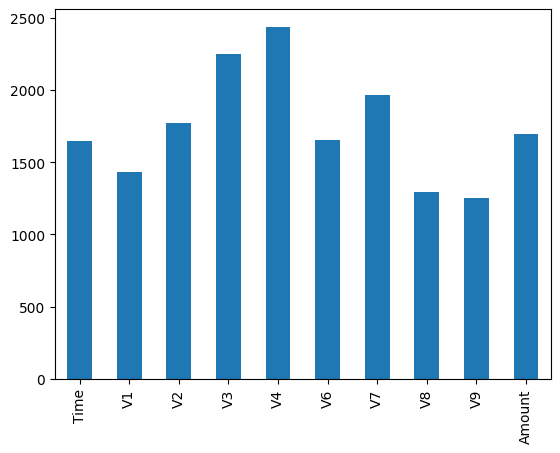

In [25]:
# 변수 중요도 시각화
val_imp['imp'].plot(kind='bar')

  - 중요도 정보가 데이터 프레임에 있기 때문에 데이터프레임의 정렬 함수를 이용합니다.

<Axes: >

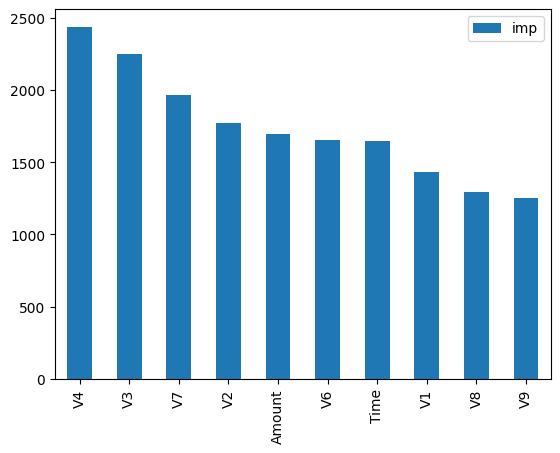

In [27]:
val_imp.sort_values(by='imp', ascending=False).plot(kind='bar')

# 모델의 저장과 불러오기

In [28]:
import pickle

In [29]:
# 저장 객체 정의
save_object = [model, params, valid_data]

In [30]:
# 저장
with open(file='my_model.pickle', mode='wb') as f:
    pickle.dump(save_object, f)

In [31]:
# 저장된 객체 불러오기
with open(file='my_model.pickle', mode='rb') as f:
    load_object = pickle.load(f)

In [32]:
# 저장된 객체 분리
model = load_object[0]
params = load_object[1]
valid_data = load_object[2]

In [33]:
# 예측
valid_data['pred'] = model.predict_proba(x_valid)[:, 1]
valid_data


,Time,V1,V2,V3,V4,V6,V7,V8,V9,Amount,Class,pred
280000,169243.0,-1.764854,-1.008565,-1.446101,0.063075,-1.618682,0.333263,0.129326,-0.656255,40.98,0,0.001378
280001,169243.0,-1.829431,2.410933,-2.228766,-0.909502,-0.009877,-0.484311,0.606725,-0.191322,13.99,0,0.001340
280002,169243.0,2.050538,-0.108752,-1.108436,0.412787,-1.185967,0.165327,-0.308987,0.609326,9.97,0,0.001378
280003,169244.0,2.272461,-0.472050,-2.718870,-1.176254,-0.847020,0.377285,-0.465128,-1.395514,20.00,0,0.001435
280004,169244.0,-3.169808,3.284481,-3.177841,-0.755452,-0.680722,-1.349915,2.577028,-0.168998,0.89,0,0.001345
...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-2.606837,-4.918215,7.305334,1.914428,0.77,0,0.001554
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,1.058415,0.024330,0.294869,0.584800,24.79,0,0.001378
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,3.031260,-0.296827,0.708417,0.432454,67.88,0,0.001435
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,0.623708,-0.686180,0.679145,0.392087,10.00,0,0.001384


In [34]:
# 검증
score = roc_auc_score(valid_data['Class'], valid_data['pred'])

print('ROC AUC Score = ', score)

ROC AUC Score =  0.970981678117843


In [35]:
# 0.9654903185509056
# 0.9692119508640433 - n_estimators 500 -> 600 으로 성능 향상
# 0.9709816781178430 - n_estimators 500 -> 600, V5 컬럼 제거 후 성능 향상

In [36]:
0.9709816781178430 - 0.9654903185509056

0.005491359566937359

# [실습 결과 ]

- 본 프로그램은 Baseline 프로그램으로 입력 값에 따른 카드거래 이상여부를 예측하는 분류 문제입니다.
- 따라서 카드거래 이상여부 예측이 실제 이상여부와 동일해야 한다.
